In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear

## Setting up the solution 1D

u_x = f(x)

In [2]:
def u(x):
    func = 2*x**3 - 3*x**2 + x
    return func
    
def uxx(x):
    func = 12*x - 6
    return func

In [3]:
def u(x):
    return torch.exp(-x) - torch.sin(x)
def uxx(x):
    return torch.exp(-x) + torch.sin(x)

In [4]:
x = torch.rand(100,1, requires_grad=True)
u_exact = u(x)
x_b = torch.tensor([[0.0], [1.0]], requires_grad=True)
u_b = u(x_b)
u_xx = uxx(x)

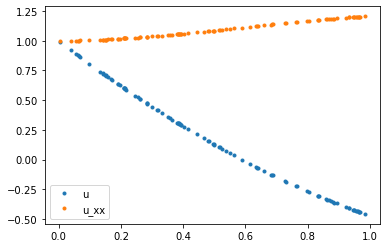

In [5]:
plt.plot(x.detach(), u_exact.detach(), '.', label='u')
plt.plot(x.detach(), u_xx.detach(), '.', label='u_xx')
plt.legend()

In [6]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam
                ):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                          out_features=N_hid,
                          bias=True),
                nn.Sigmoid(),
                nn.Linear(in_features=N_hid,
                          out_features=N_out,
                          bias=True)
        )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        
    def forward(self, x):
        out = self.layers(x)
        return out
    
    def loss_BC(self, x_b, u_b):
        u_b_hat = self.forward(x_b)
        loss = self.loss_func(u_b, u_b_hat)
        return loss

    def loss_PDE(self, x, u_xx):
        u_hat = self.forward(x)
        u_x_hat = torch.autograd.grad(u_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_xx_hat = torch.autograd.grad(u_x_hat, x, torch.ones(x.shape), create_graph=True)[0]
        loss = self.loss_func(u_xx, u_xx_hat)
        return loss
    
    def loss(self, x, u_xx, x_b, u_b):
        loss = self.loss_BC(x_b, u_b) + self.loss_PDE(x, u_xx)
        return loss
    
    def step(self, x, u_xx, x_b, u_b ):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, u_xx, x_b, u_b)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return self.loss_BC(x_b, u_b), self.loss_PDE(x, u_xx)

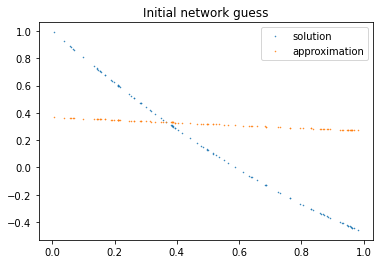

In [7]:
loss = []
epochs = 10000
N_in = 1
N_out = 1
net = Net(N_in, N_out, N_hid=10)
plt.plot(x.detach(), u_exact.detach(), '.', label='solution', markersize=1)
plt.plot(x.detach(), net(x).detach(), '.', label='approximation', markersize=1)
plt.legend()
plt.title('Initial network guess')

for e in range(epochs):
    loss.append(net.step(x, u_xx, x_b, u_b))

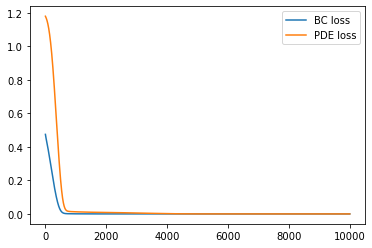

In [8]:
plt.plot([bc.detach() for bc, pde in loss], label='BC loss')
plt.plot([pde.detach() for bc, pde in loss], label='PDE loss')
#plt.loglog([pde.detach() + bc.detach() for bc, pde in loss], label='Loss')


plt.legend()

Text(0.5, 1.0, 'Trained network estimate')

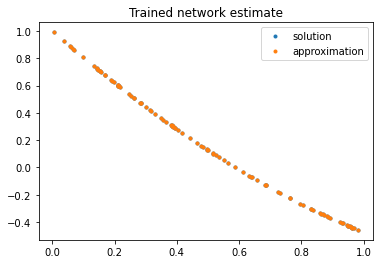

In [9]:
plt.plot(x.detach(), u_exact.detach(), '.', label='solution')
plt.plot(x.detach(), net(x).detach(), '.', label='approximation')
plt.legend()
plt.title('Trained network estimate')

Text(0.5, 1.0, 'Initial network guess')

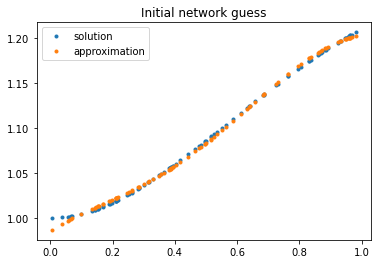

In [10]:
u_x_hat = torch.autograd.grad(net(x), x, torch.ones(x.shape), create_graph=True)[0]
u_xx_hat = torch.autograd.grad(u_x_hat, x, torch.ones(x.shape))[0]
plt.plot(x.detach(), u_xx.detach(), '.', label='solution')
plt.plot(x.detach(), u_xx_hat.detach(), '.', label='approximation')
plt.legend()
plt.title('Initial network guess')